In [3]:
tempM = 25 # max epochs

# Individual Assignment I - Notebook 1 (Basic CNN Architectures)
 \
By Arham Anwar

-----

### Introduction to SimpleCNN for CIFAR-10
This notebook is part 1 out of 3 for the individual submission 1 of Assignment 1. This notebook features all Simple CNN architectures tried and the rationale behing them. In other notebooks we will cover resnet and EfficientNet. SimpleCNN is a convolutional neural network designed specifically for image classification tasks on the CIFAR-10 dataset. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The architecture of SimpleCNN is tailored to efficiently learn distinctive features from these small images and perform accurate classification. I tried three different variants - 

**1. Simple CNN without Optuna Trials** \
**2. Simple CNN with 5 Optuna Trials** \
**3. Simple CNN With custom edits** \

All variants were tracked using tensorboard in addition to other notebooks


------

### 1. Vanilla Basic CNN without Optuna

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics

class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)  # Corrected to add this missing fully connected layer
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Correct usage of fc2
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=self.transform)
            self.train_data, self.val_data = torch.utils.data.random_split(cifar_train, [45000, 5000])
        if stage == 'test' or stage is None:
            self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size)

model = SimpleCNN()
data_module = CIFAR10DataModule()
trainer = Trainer(max_epochs=tempM)
trainer.fit(model, data_module)
trainer.test(model, data_module)

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)
2024-05-20 02:05:20.987403: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 02:05:26.972335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 24: 100%|██████████| 1564/1564 [02:00<00:00, 12.94it/s, loss=0.0628, v_num=4] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1564/1564 [02:00<00:00, 12.94it/s, loss=0.0628, v_num=4]
Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 313/313 [00:07<00:00, 40.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6952999830245972     │
│         test_loss         │     2.901397943496704     │
└───────────────────────────┴───────────────────────────┘

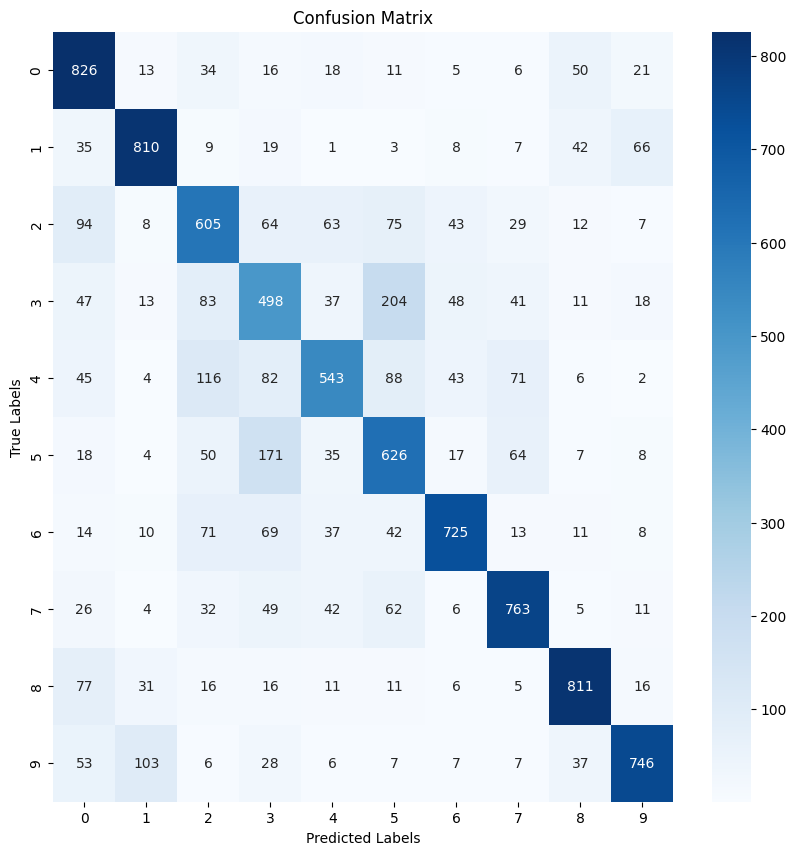

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def plot_validation_curve(model, train_dataloader, val_dataloader, epochs):
    model.eval()
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            # Compute training loss
            for images, labels in train_dataloader:
                outputs = model(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                train_loss += loss.item()

            # Compute validation loss and accuracy
            for images, labels in val_dataloader:
                outputs = model(images)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_dataloader))
        val_losses.append(val_loss / len(val_dataloader))
        val_accuracies.append(correct / total)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, data_module.test_dataloader())


--------
## 2. Simple CNN implementation with Optuna Tuning

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-20 05:31:22,897] A new study created in memory with name: no-name-c66f0322-34ef-475a-a504-a1134757e20c
/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1564/1564 [01:21<00:00, 19.28it/s, loss=0.895]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1564/1564 [01:21<00:00, 19.28it/s, loss=0.895]

[I 2024-05-20 05:37:54,640] Trial 0 finished with value: 1.120657205581665 and parameters: {'learning_rate': 0.0032859724122979196}. Best is trial 0 with value: 1.120657205581665.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1564/1564 [01:16<00:00, 20.49it/s, loss=0.407]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1564/1564 [01:16<00:00, 20.49it/s, loss=0.407]

[I 2024-05-20 05:44:22,757] Trial 1 finished with value: 0.9545965790748596 and parameters: {'learning_rate': 0.0014808520242948033}. Best is trial 1 with value: 0.9545965790748596.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1564/1564 [01:19<00:00, 19.64it/s, loss=1.07]    

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1564/1564 [01:19<00:00, 19.64it/s, loss=1.07]

[I 2024-05-20 05:51:08,587] Trial 2 finished with value: 1.0883100032806396 and parameters: {'learning_rate': 6.965481135742228e-05}. Best is trial 1 with value: 0.9545965790748596.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1564/1564 [01:16<00:00, 20.48it/s, loss=0.805]   

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1564/1564 [01:16<00:00, 20.48it/s, loss=0.805]

[I 2024-05-20 05:57:33,886] Trial 3 finished with value: 1.0609748363494873 and parameters: {'learning_rate': 0.0028630323228340665}. Best is trial 1 with value: 0.9545965790748596.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified



  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)


Epoch 4: 100%|██████████| 1564/1564 [01:17<00:00, 20.29it/s, loss=2.3]     

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1564/1564 [01:17<00:00, 20.29it/s, loss=2.3]

[I 2024-05-20 06:04:07,059] Trial 4 finished with value: 2.3033287525177 and parameters: {'learning_rate': 0.010183500152991232}. Best is trial 1 with value: 0.9545965790748596.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 1564/1564 [02:15<00:00, 11.58it/s, loss=1, v_num=3]    

Metric val_loss improved. New best score: 1.059


Epoch 1: 100%|██████████| 1564/1564 [02:14<00:00, 11.66it/s, loss=0.827, v_num=3]

Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 0.939


Epoch 2: 100%|██████████| 1564/1564 [02:12<00:00, 11.80it/s, loss=0.666, v_num=3]

Metric val_loss improved by 0.084 >= min_delta = 0.0. New best score: 0.854


Epoch 5: 100%|██████████| 1564/1564 [02:11<00:00, 11.87it/s, loss=0.262, v_num=3]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.854. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 1564/1564 [02:12<00:00, 11.83it/s, loss=0.262, v_num=3]
Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 313/313 [00:15<00:00, 20.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7042999863624573     │
│         test_loss         │    1.1338746547698975     │
└───────────────────────────┴───────────────────────────┘

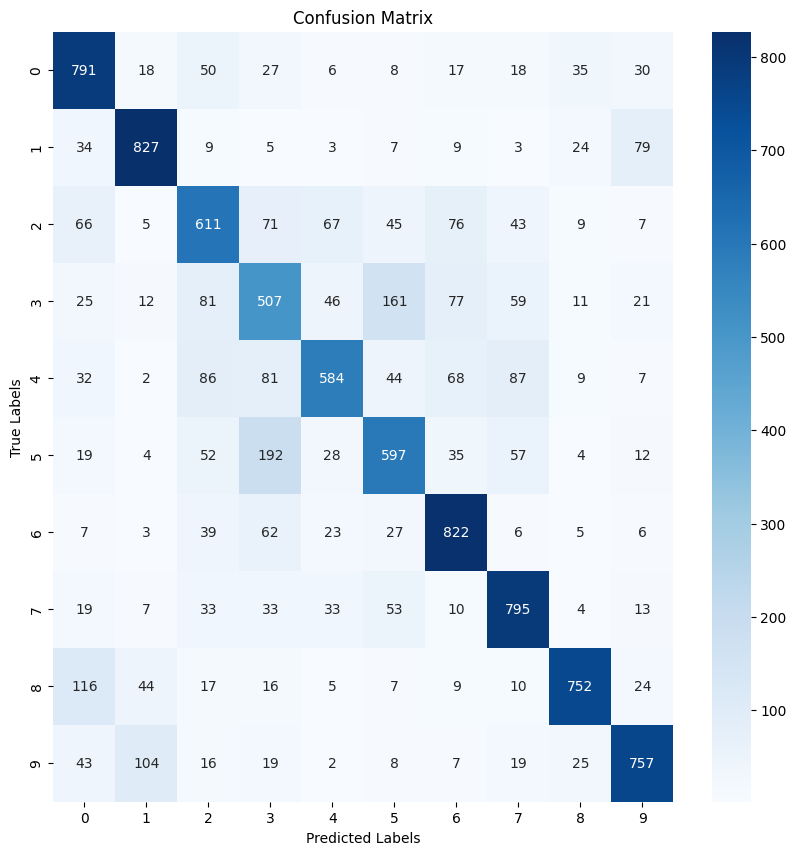

ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

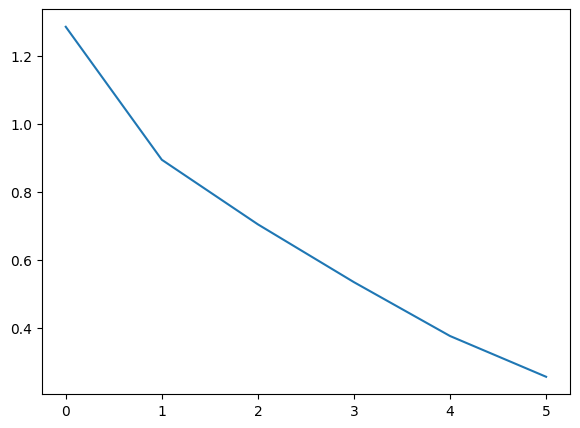

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import optuna
from pytorch_lightning import seed_everything

class SimpleCNN(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super(SimpleCNN, self).__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log('avg_train_loss', avg_loss, on_epoch=True)
        self.train_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log('avg_val_loss', avg_loss, on_epoch=True)
        self.val_losses.append(avg_loss.item())

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=self.transform)
            self.train_data, self.val_data = torch.utils.data.random_split(cifar_train, [45000, 5000])
        if stage == 'test' or stage is None:
            self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size)

# Hyperparameter optimization with Optuna
def objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model = SimpleCNN(learning_rate=learning_rate)
    data_module = CIFAR10DataModule()

    trainer = Trainer(
        max_epochs=5,
        gpus=1 if torch.cuda.is_available() else 0,
        logger=False,
        enable_checkpointing=False
    )

    trainer.fit(model, datamodule=data_module)

    val_loss = trainer.callback_metrics["val_loss"].item()
    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

best_trial = study.best_trial
best_learning_rate = best_trial.params["learning_rate"]

# Set up TensorBoard logger and model checkpoint
logger = TensorBoardLogger("tb_logs", name="cifar10_model")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="cifar10-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

# Instantiate the model and data module with best learning rate
model = SimpleCNN(learning_rate=best_learning_rate)
data_module = CIFAR10DataModule()

# Instantiate the trainer
trainer = Trainer(
    max_epochs=50,  # Increased to allow for early stopping
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Train the model
trainer.fit(model, data_module)
trainer.test(model, data_module)

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def plot_validation_curve(train_losses, val_losses):
    epochs = range(len(train_losses))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()



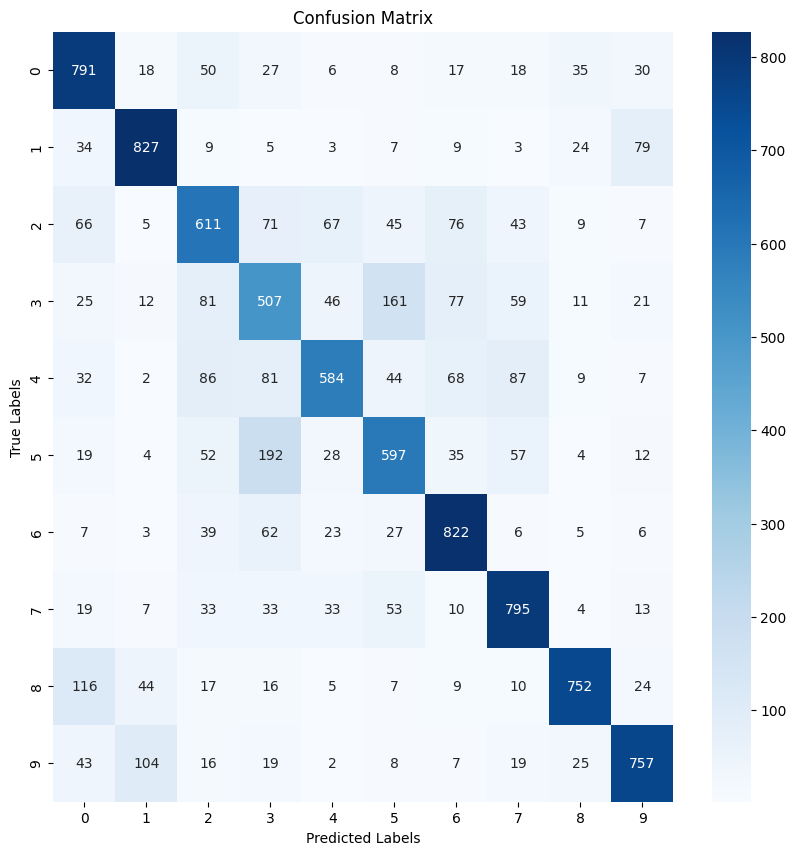

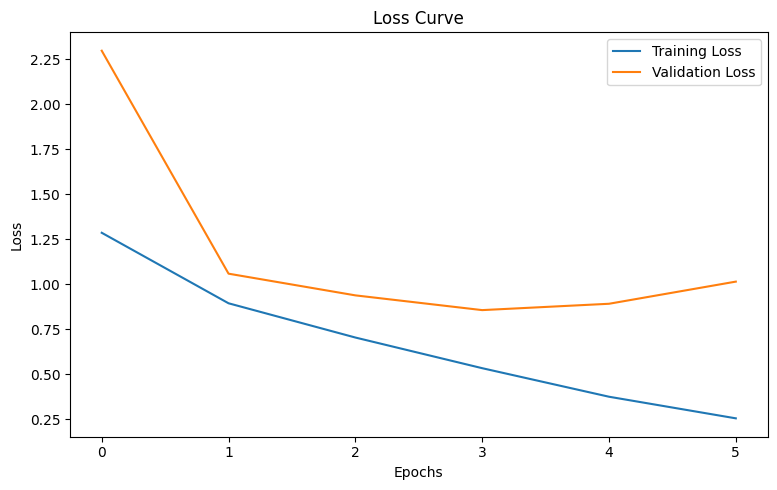

In [4]:
# Plot confusion matrix
plot_confusion_matrix(model, data_module.test_dataloader())

# Plot validation and training curves
plot_validation_curve(model.train_losses, model.val_losses[:-1])

In [5]:
# tensorboard launch
%tensorboard --logdir tb_logs --port 6006

UsageError: Line magic function `%tensorboard` not found.


------
## 3. Without Otpuna curves custom edit

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class SimpleCNN(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super(SimpleCNN, self).__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log('avg_train_loss', avg_loss, on_epoch=True)
        self.train_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log('avg_val_loss', avg_loss, on_epoch=True)
        self.val_losses.append(avg_loss.item())

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=self.transform)
            self.train_data, self.val_data = torch.utils.data.random_split(cifar_train, [45000, 5000])
        if stage == 'test' or stage is None:
            self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size)

# Set up TensorBoard logger and model checkpoint
logger = TensorBoardLogger("tb_logs", name="cifar10_model")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="cifar10-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

# Instantiate the model and data module with best learning rate
model = SimpleCNN(learning_rate=0.001)
data_module = CIFAR10DataModule()

# Instantiate the trainer
trainer = Trainer(
    max_epochs=10,  # Increased to allow for early stopping
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Train the model
trainer.fit(model, data_module)
trainer.test(model, data_module)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


Missing logger folder: tb_logs/cifar10_model

  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)
2024-05-20 03:39:41.855969: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 03:39:48.814539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Epoch 0: 100%|██████████| 1564/1564 [01:33<00:00, 16.67it/s, loss=0.995, v_num=0]

Metric val_loss improved. New best score: 1.077


Epoch 1: 100%|██████████| 1564/1564 [01:28<00:00, 17.65it/s, loss=0.827, v_num=0]

Metric val_loss improved by 0.150 >= min_delta = 0.0. New best score: 0.927


Epoch 2: 100%|██████████| 1564/1564 [01:29<00:00, 17.41it/s, loss=0.697, v_num=0]

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 0.828


Epoch 5: 100%|██████████| 1564/1564 [01:39<00:00, 15.80it/s, loss=0.225, v_num=0]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.828. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 1564/1564 [01:39<00:00, 15.78it/s, loss=0.225, v_num=0]
Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 313/313 [00:12<00:00, 24.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7063999772071838     │
│         test_loss         │    1.1547480821609497     │
└───────────────────────────┴───────────────────────────┘

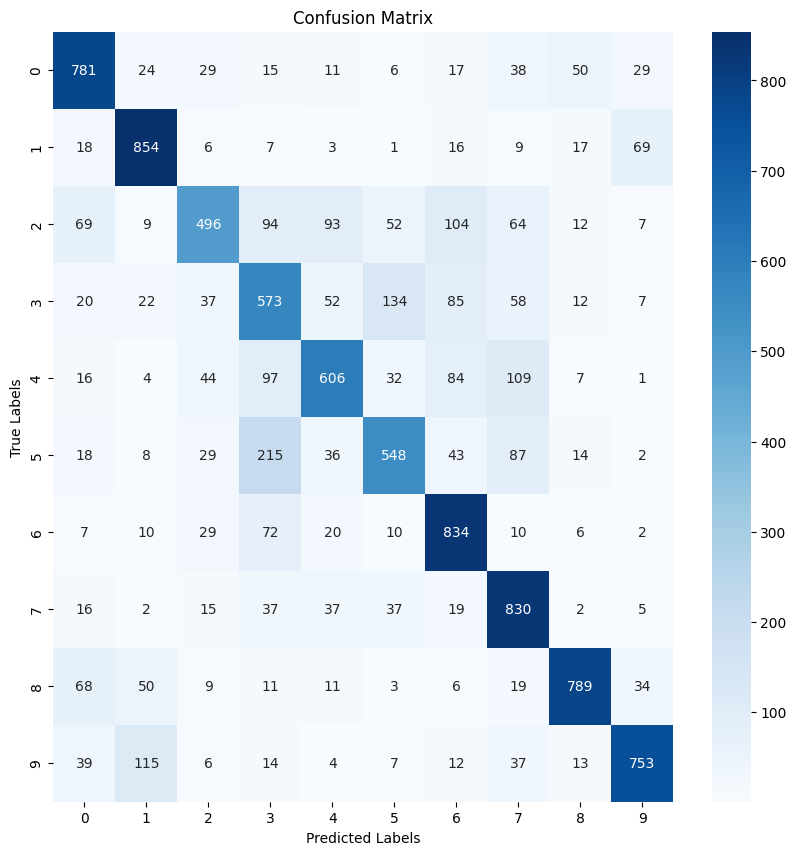

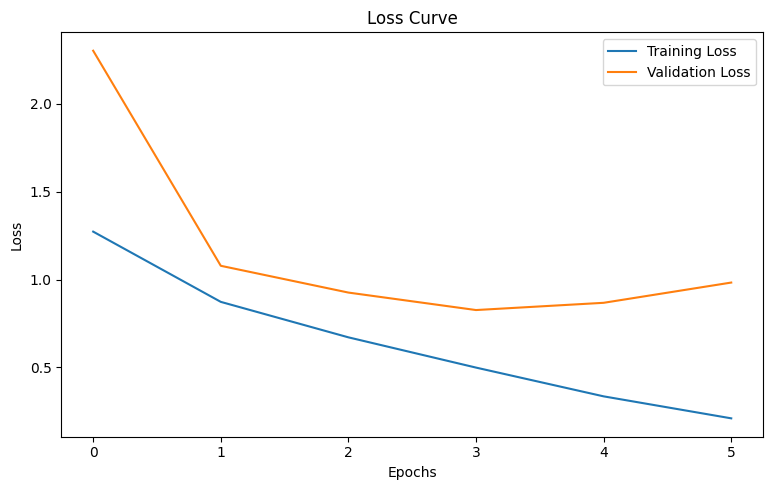

AttributeError: 'list' object has no attribute 'eval'

In [11]:
# import confusion_matrix, classification_report, and plot_confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

def plot_validation_curve(train_losses, val_losses):
    epochs = range(len(train_losses))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, data_module.test_dataloader())

# Plot validation and training curves
plot_validation_curve(model.train_losses, model.val_losses[:-1])



In [14]:
from sklearn.metrics import classification_report
import torch

# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Iterate over the test dataset
for batch in data_module.test_dataloader():
    images, labels = batch
    # Forward pass
    outputs = model(images)
    # Get predictions
    _, predicted = torch.max(outputs, 1)
    # Append predictions and labels to the lists
    all_predictions.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Generate classification report
report = classification_report(all_labels, all_predictions)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.78      0.85      0.81      1000
           2       0.71      0.50      0.58      1000
           3       0.50      0.57      0.54      1000
           4       0.69      0.61      0.65      1000
           5       0.66      0.55      0.60      1000
           6       0.68      0.83      0.75      1000
           7       0.66      0.83      0.73      1000
           8       0.86      0.79      0.82      1000
           9       0.83      0.75      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.70     10000
weighted avg       0.71      0.71      0.70     10000



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/home/codespace/.python/current/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name     | Type               | Params
------------------------------------------------
0 | conv1    | Conv2d             | 896   
1 | conv2    | Conv2d             | 18.5 K
2 | pool     | MaxPool2d          | 0     
3 | fc1      | Linear             | 2.1 M 
4 | fc2      | Linear             | 5.1 K 
5 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.489     Total estimated model params size (MB)
2024-05-20 04:07:38.845460: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the followi

Epoch 0: 100%|██████████| 1564/1564 [01:40<00:00, 15.49it/s, loss=1.01, v_num=2] 

Metric val_loss improved. New best score: 1.049


Epoch 1: 100%|██████████| 1564/1564 [01:35<00:00, 16.31it/s, loss=0.835, v_num=2]

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 0.934


Epoch 2: 100%|██████████| 1564/1564 [01:30<00:00, 17.22it/s, loss=0.697, v_num=2]

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 0.799


Epoch 2: 100%|██████████| 1564/1564 [01:30<00:00, 17.22it/s, loss=0.697, v_num=2]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1564/1564 [01:30<00:00, 17.20it/s, loss=0.697, v_num=2]
Files already downloaded and verified
Files already downloaded and verified
Testing DataLoader 0: 100%|██████████| 313/313 [00:10<00:00, 31.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7164000272750854     │
│         test_loss         │    0.8255926966667175     │
└───────────────────────────┴───────────────────────────┘

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

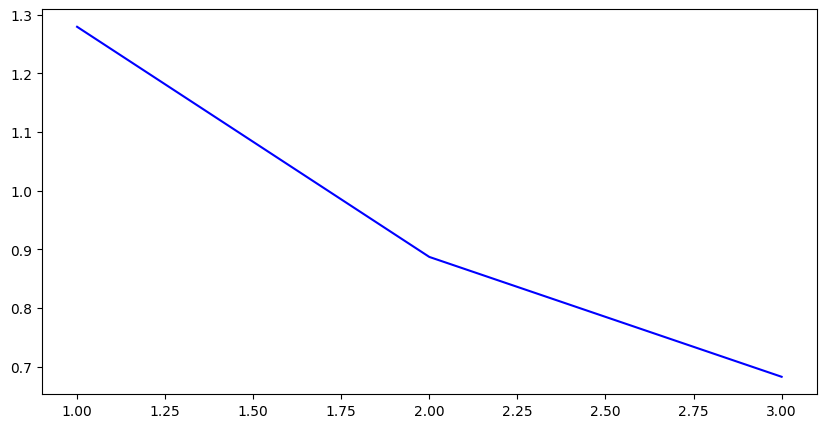

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class SimpleCNN(pl.LightningModule):
    def __init__(self, learning_rate=0.001):
        super(SimpleCNN, self).__init__()
        self.save_hyperparameters()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('train_loss', loss)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log('avg_train_loss', avg_loss, on_epoch=True)
        self.train_losses.append(avg_loss.item())

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('val_loss', loss)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log('avg_val_loss', avg_loss, on_epoch=True)
        self.val_losses.append(avg_loss.item())

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        acc = self.accuracy(outputs, labels)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def prepare_data(self):
        torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, transform=self.transform)
            self.train_data, self.val_data = torch.utils.data.random_split(cifar_train, [45000, 5000])
        if stage == 'test' or stage is None:
            self.test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=self.transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size)

# Set up TensorBoard logger and model checkpoint
logger = TensorBoardLogger("tb_logs", name="cifar10_model")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="cifar10-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=True,
    mode='min'
)

# Instantiate the model and data module with best learning rate
model = SimpleCNN(learning_rate=0.001)
data_module = CIFAR10DataModule()

# Instantiate the trainer
trainer = Trainer(
    max_epochs=3,  # Increased to allow for early stopping
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    log_every_n_steps=10
)

# Train the model
trainer.fit(model, data_module)
trainer.test(model, data_module)

# Visualize training and validation losses
def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(model.train_losses, model.val_losses[:-1])
